# Figure 15.

Day-night surface temperature difference ($\overline{\Delta T_{dn}}$, $K$) as a function of the average wind divergence in the free troposphere ($5-20~km$) of the substellar region ($\overline{\nabla\cdot\vec{u}}_{ss}$, $s^{-1}$) for the ensemble of simulations with different empirical parameters of the mass-flux scheme (gray markers) in (a) Trappist-1e and (b) Proxima b set-up. The blue marker shows the value for the control simulation, i.e. *MassFlux*. The dashed blue line shows linear fit, and the dark blue vertical lines show the divergence estimate from the *HighRes* simulation, along with extrapolated $\overline{\Delta T_{dn}}$ (horizontal dashed lines). Dark blue shaded area represents the uncertainty in high-resolution estimates due to the temporal variability.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime, timedelta

Progress bar

In [3]:
from fastprogress import progress_bar

Scientific stack

In [4]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn import linear_model

import xarray as xr

In [5]:
from aeolus.util import subplot_label_generator

Local modules

In [6]:
from commons import (
    ENS_LABELS,
    GLM_RUNID,
    NS_COLORS,
    NS_MODEL_TYPES,
    NS_OUTPUT_NAME_PREFIX,
    NS_RUN_ALIASES,
    PLANET_ALIASES,
    SS_REGION,
)
from gl_diag import ONLY_LAM
import mypaths
from plot_func import use_style

Global stylesheet for figures.

In [7]:
use_style()

Make a simple wrapper for the linear regression

In [8]:
def _simple_lin_reg(x, y):
    """Linear regression of y against x using scikit-learn."""
    xx = x.values.reshape((-1, 1))
    yy = y.values.reshape((-1, 1))
    wider_xx = np.linspace(
        xx.min() * (1 - 0.05 * np.sign(xx.min())),
        xx.max() * (1 + 0.05 * np.sign(xx.max())),
        2,
    ).reshape(-1, 1)
    lin_reg = linear_model.LinearRegression().fit(xx, yy)
    y_pred = lin_reg.predict(wider_xx)
    score = lin_reg.score(xx, yy)

    return lin_reg, score, wider_xx, y_pred

In [9]:
run_key = "grcs"

## Load data

First, load preprocessed metrics of the _HighRes_ simulations

In [10]:
nc_flist = sorted((mypaths.nsdir / "_processed").glob("*"))
# nc_flist

In [11]:
lam_results = {}
for planet in PLANET_ALIASES.keys():
    label = f"{planet}_{run_key}"
    try:
        lam_results[label] = xr.open_dataset(
            mypaths.nsdir / "_processed" / f"aggr_diags_ns_{label}_lam.nc"
        )
    except OSError as e:
        print(e)
        pass

Average the results

In [12]:
lam_ave = {}
for label, ds in lam_results.items():
    df = ds.to_dataframe()[[i for i in ds.data_vars]].mean()
    df.index = [i + "_ss" for i in df.index]
    df = df.to_frame()
    df.columns = [label + "_LAM"]
    lam_ave[label] = df.T

Now load the aggregated metrics of "ensemble" global simulations

In [13]:
df_ens_dict = {}
for planet in PLANET_ALIASES.keys():
    df_list = []
    for label in ENS_LABELS:
        fpath = (
            mypaths.sadir
            / f"{planet}_grcs_ensemble"
            / label
            / "_processed"
            / f"{planet}_grcs_ens_{label}_aggr_diag.csv"
        )
        df_list.append(pd.read_csv(fpath, index_col=0).T)
    df_ens_dict[planet] = pd.concat(df_list, axis=0, sort=False)

## Plot the results

Define a function to plot regression with all the bells and whistles.

In [14]:
def scatter_plot_w_lin_reg(ax, x_vrbl, y_vrbl, ds_x, add_legend=True):
    x = x_vrbl
    y = y_vrbl

    # Calculate regression
    lin_reg, score, x_lin, y_lin = _simple_lin_reg(x, y)

    try:
        ax.plot(
            x.loc["base"],
            y.loc["base"],
            linestyle="",
            marker=".",
            color=NS_COLORS[run_key]["lam"],
            ms=12,
            label=NS_RUN_ALIASES[run_key],
            zorder=100,
        )
    except KeyError:
        pass
    ax.plot(
        x.squeeze(),
        y.squeeze(),
        linestyle="",
        marker=".",
        color="grey",
        alpha=0.75,
        ms=10,
        label=f"{NS_RUN_ALIASES[run_key]} with\nperturbed parameters",
    )

    ns_predict = None
    # NS data
    ns_estimate_mean = float(ds_x.mean())
    ns_predict = float(lin_reg.predict(np.array(ns_estimate_mean).reshape((-1, 1))))
    ns_estimate_std = float(ds_x.std())
    xx = np.concatenate(
        [x, [ds_x.mean(), ds_x.mean() + ds_x.std(), ds_x.mean() - ds_x.std()]]
    )
    wider_xx = np.linspace(
        xx.min() * (1 - 0.05 * np.sign(xx.min())),
        xx.max() * (1 + 0.05 * np.sign(xx.max())),
        2,
    ).reshape(-1, 1)

    ax.plot(
        wider_xx.squeeze(),
        lin_reg.predict(wider_xx).squeeze(),
        linestyle="--",
        color=NS_COLORS[run_key]["global"],
        label="Linear regression",
    )

    ylim = ax.get_ylim()

    ns_predict_upper = float(
        lin_reg.predict(np.array(ns_estimate_mean + ns_estimate_std).reshape((-1, 1)))
    )
    ns_predict_lower = float(
        lin_reg.predict(np.array(ns_estimate_mean - ns_estimate_std).reshape((-1, 1)))
    )
    ax.vlines(
        ns_estimate_mean,
        *ylim,
        color=NS_COLORS[run_key]["lam"],
        linewidth=3,
        label=f"{NS_MODEL_TYPES['lam']['title']} estimate",
    )
    ax.fill_betweenx(
        ylim,
        ns_estimate_mean - ns_estimate_std,
        ns_estimate_mean + ns_estimate_std,
        alpha=0.5,
        facecolor=NS_COLORS[run_key]["lam"],
        edgecolor="none",
        label=NS_MODEL_TYPES["lam"]["title"] + r" uncertainty ($\pm\sigma$)",
    )

    xlim = ax.get_xlim()

    if ns_predict is not None:
        # print(ns_predict_lower)
        # print(ns_predict)
        # print(ns_predict_upper)
        ax.plot(
            [xlim[0], ns_estimate_mean],
            [ns_predict] * 2,
            marker="o",
            markevery=[-1],
            linestyle="--",
            linewidth=3,
            color=NS_COLORS[run_key]["lam"],
        )
        ax.plot(
            [xlim[0], ns_estimate_mean - ns_estimate_std],
            [ns_predict_lower] * 2,
            marker="o",
            mfc="none",
            alpha=0.5,
            markevery=[-1],
            linestyle="--",
            linewidth=2,
            color=NS_COLORS[run_key]["lam"],
        )
        ax.plot(
            [xlim[0], ns_estimate_mean + ns_estimate_std],
            [ns_predict_upper] * 2,
            marker="o",
            mfc="none",
            alpha=0.5,
            markevery=[-1],
            linestyle="--",
            linewidth=2,
            color=NS_COLORS[run_key]["lam"],
        )
        if (abs(ax.get_yticks() - ns_predict) >= 1.5).all():
            ax.set_yticks(list(ax.get_yticks()) + [np.round(ns_predict, 1)])
    ax.set_ylim(*ylim)
    ax.set_xlim(*xlim)

    if add_legend:
        ax.legend(loc=1, fontsize="small")  # , bbox_to_anchor=[1.0, 1.0]

    return lin_reg

Dictionary with x-diagnostics (here only the horizontal divergence is left).

In [15]:
chosen_x_diags = {
    "hdiv_5_20km_ss": {
        "factor": 1e6,
        "xlabel": "Horizontal divergence in the upper troposphere\n"
        + r"of the substellar region $\overline{\nabla \cdot \vec{u}}_{ss}$ [$10^{-6}$ $s^{-1}$]",
    },
}

Choose variables for the regression.

In [16]:
x_name = "hdiv_5_20km_ss"
y_name = "t_sfc_diff_dn"

Assemble the figure.

In [17]:
ncol = len(PLANET_ALIASES)
nrow = 1

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(8 * ncol, 4 * nrow))

iletters = subplot_label_generator()
for i, (planet, ax) in enumerate(zip(PLANET_ALIASES, axs.T)):
    ax.set_title(f"({next(iletters)})", fontsize="small", pad=5, loc="left")
    ax.set_title(PLANET_ALIASES[planet], fontsize="large", pad=5, loc="center")

    y_vrbl = df_ens_dict[planet][y_name]
    x_vrbl = df_ens_dict[planet][x_name] * chosen_x_diags[x_name]["factor"]
    ds_x = (
        lam_results[f"{planet}_{run_key}"][x_name.replace("_ss", "")]
        * chosen_x_diags[x_name]["factor"]
    )

    lr = scatter_plot_w_lin_reg(
        ax, x_vrbl=x_vrbl, y_vrbl=y_vrbl, ds_x=ds_x, add_legend=(i == 0),
    )

    ax.set_xlabel(
        chosen_x_diags[x_name]["xlabel"], fontsize="medium",
    )

    if ax.is_first_col():
        ax.set_ylabel(
            "Surface day-night temperature\n"
            + r"difference $\overline{\Delta T_{dn}}$ [$K$]",
            fontsize="medium",
        )
plt.subplots_adjust(wspace=0.15, hspace=0.3)

plt.close()  # Show the figure in a separate cell

## Show the figure

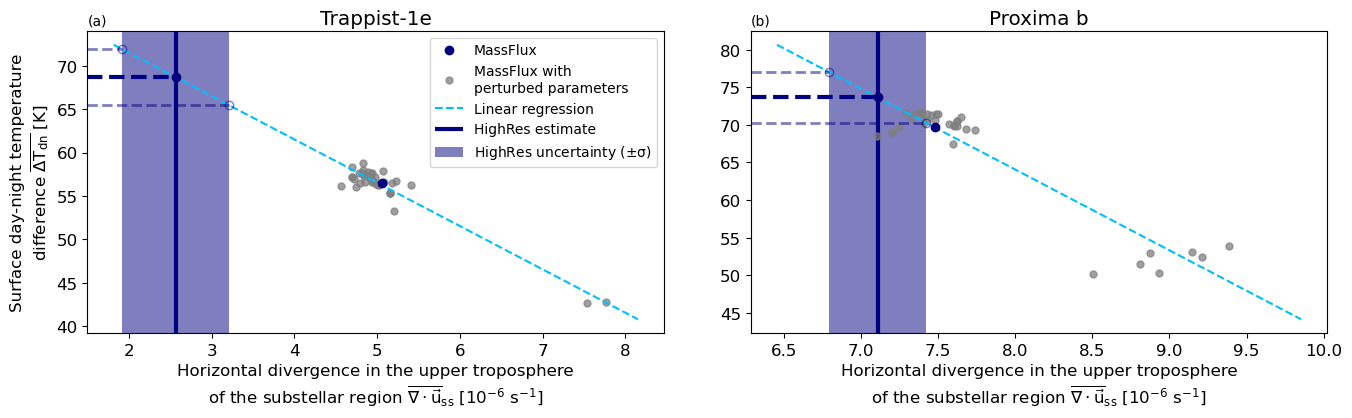

In [18]:
fig

And save it.

In [19]:
imgname = (
    mypaths.plotdir / f"{NS_OUTPUT_NAME_PREFIX}__scatter_w_linreg__{x_name}__{y_name}"
)

In [20]:
fig.savefig(imgname, dpi=200)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}")

Saved to ../plots/trap1e_proxb__grcs__scatter_w_linreg__hdiv_5_20km_ss__t_sfc_diff_dn
